# Replication script for the paper "Exploting Unit Test Generators for Code to Generate Abstract Tests for Models"

This script is used to replicate the results of the analyses presented in the paper.

## Data preparation


In [316]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

Loading the necessary data

We read, for each of the 10 runs, the file `data.csv` that contains the results of the test generation process with the three approaches: **random**, **atgt**, and **evoavalla**

In [317]:
# Define a general dataframe to hold all data
all_data = pd.DataFrame()

for i in range(10):
    # Create a directory for each run
    data_file_path = f'results/run{i}/data.csv'

    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(data_file_path)

    # Add a new column 'run' with the value of i
    df['run'] = i

    # Append the dataframe to the all_data dataframe
    all_data = pd.concat([all_data, df], ignore_index=True)

It may happen that some of the entries are not available in the file, because the test generation process did not finish or it failed. In this case, we fill the entries in the dataframe with `NaN` values.

In [318]:
# We need to fill the dataframe. For each asm and each run, we need values with approach = evoavalla, approach = random, and approach = atgt. If they are not present, we need to fill them with NaN
asms = all_data['asm'].unique()
approaches = all_data['approach'].unique()

for asm in asms:
    for run in range(10):
        for approach in approaches:
            # Check if the combination exists
            if not ((all_data['asm'] == asm) & (all_data['run'] == run) & (all_data['approach'] == approach)).any():
                # If it doesn't exist, create a new row with NaN values
                new_row = {
                    'asm': asm,
                    'run': run,
                    'approach': approach,
                    'n_failing_scenarios': float('nan'),
                    'update_rule_coverage': float('nan'),
                    'branch_coverage': float('nan'),
                    'macro_coverage': float('nan'),
                    'n_checks': float('nan'),
                    'n_sets': float('nan'),
                    'n_step': float('nan'),
                    'n_scenarios': 0,
                    'n_val_error_scenarios': float('nan'),
                }
                # all_data = all_data.append(new_row, ignore_index=True) # append removed since pandas 2.0
                all_data = pd.concat([all_data, pd.DataFrame([new_row])], ignore_index=True)

In [319]:
# Rename approach atgt to ATGT
all_data['approach'] = all_data['approach'].replace('atgt', 'ATGT')
# Rename approach evoavalla to EvoAValla
all_data['approach'] = all_data['approach'].replace('evoavalla', 'EvoAvalla')
# Rename approach random to Random
all_data['approach'] = all_data['approach'].replace('random', 'Random')
# Remove all rows with approach = random100
all_data = all_data[all_data['approach'] != 'random100']
# Print the number of distinct asms
print("Number of distinct asms: ", all_data['asm'].nunique())

Number of distinct asms:  15


## RQ1: Success rate

Approach: EvoAvalla, Number of unique asms with n_scenarios = 0 or NaN: 3 - ['ATM' 'Tcas' 'IntegerTrain']
Approach: Random, Number of unique asms with n_scenarios = 0 or NaN: 1 - ['IntegerTrain']
Approach: ATGT, Number of unique asms with n_scenarios = 0 or NaN: 7 - ['ATM' 'CashPoint' 'CashRegister' 'DiceGame' 'IntegerTrain' 'SiGistica'
 'Stove']


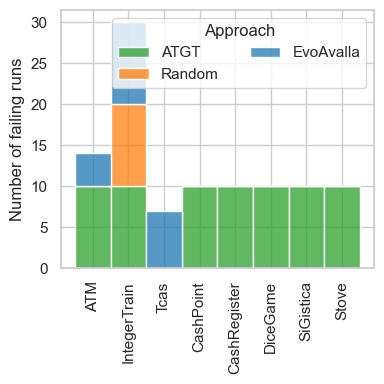

In [320]:
# For each approach, calculate the number of distinc asm for which at least one run produced n_scenarios = 0 or n_scenarios = NaN
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Get the unique asms for which at least one run produced n_scenarios = 0 or n_scenarios = NaN
    unique_asms = approach_data[(approach_data['n_scenarios'] == 0) | (approach_data['n_scenarios'].isna())]['asm'].unique()

    # Print the results
    print(f"Approach: {approach}, Number of unique asms with n_scenarios = 0 or NaN: {len(unique_asms)} - {unique_asms}")

# Create an histogram showing the number of asms for each technique for which at least one run produced n_scenarios = 0 or n_scenarios = NaN
plt.figure(figsize=(4, 4))
# Create a histogram with seaborn
sns.histplot(data=all_data[(all_data['n_scenarios'] == 0) | (all_data['n_scenarios'].isna())], x='asm', hue='approach', multiple='stack')
plt.ylabel('Number of failing runs')
plt.xticks(rotation=90)
plt.xlabel('')
plt.tight_layout()
# Set the legend 
plt.legend(title='Approach', loc='upper right', labels=['ATGT', 'Random', 'EvoAvalla'], ncols=2)

# Save the image as pdf
plt.savefig('images/histogram_asm_zero_scenarios.pdf', bbox_inches='tight')

In [321]:
# Print for each approach, the number of entries for which n_val_error_scenarios was greater than 0
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]
    
    # Count the number of entries with n_val_error_scenarios > 0
    n_val_error_scenarios_approach = approach_data[approach_data['n_val_error_scenarios'] > 0].shape[0]
    
    # Print the results
    print(f"Approach: {approach}, Number of entries with n_val_error_scenarios > 0: {n_val_error_scenarios_approach}")

    # Print the name of the asms generated by the approach that have n_val_error_scenarios > 0 and, for each of them, the number of times in which n_val_error_scenarios > 0
    asms_with_errors = approach_data[approach_data['n_val_error_scenarios'] > 0]['asm'].value_counts()
    print(f"Approach: {approach}, Asms with n_val_error_scenarios > 0: {asms_with_errors.to_dict()}")

    # Print the name of the asms generated by the approach that have n_val_error_scenarios > 0 and, for each of them, the number of times in which n_val_error_scenarios > 0
    asms_with_errors = approach_data[approach_data['n_failing_scenarios'] > 0]['asm'].value_counts()
    print(f"Approach: {approach}, Asms with n_failing_scenarios > 0: {asms_with_errors.to_dict()}")

Approach: EvoAvalla, Number of entries with n_val_error_scenarios > 0: 6
Approach: EvoAvalla, Asms with n_val_error_scenarios > 0: {'ATM': 3, 'Tcas': 2, 'CashPoint': 1}
Approach: EvoAvalla, Asms with n_failing_scenarios > 0: {'ATM': 1}
Approach: Random, Number of entries with n_val_error_scenarios > 0: 0
Approach: Random, Asms with n_val_error_scenarios > 0: {}
Approach: Random, Asms with n_failing_scenarios > 0: {'CashPoint': 4}
Approach: ATGT, Number of entries with n_val_error_scenarios > 0: 0
Approach: ATGT, Asms with n_val_error_scenarios > 0: {}
Approach: ATGT, Asms with n_failing_scenarios > 0: {'GuessBigNumber': 10, 'LandingGearSystem': 10, 'Lift': 10}


## RQ2: Coverage

In [322]:
# For each approach, calculate the mean and standard deviation of the 'branch_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_branch_coverage = approach_data['branch_coverage'].mean()
    std_branch_coverage = approach_data['branch_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Branch Coverage: {mean_branch_coverage:.2f}, Std Dev: {std_branch_coverage:.2f}")

Approach: EvoAvalla, Mean Branch Coverage: 0.55, Std Dev: 0.30
Approach: Random, Mean Branch Coverage: 0.48, Std Dev: 0.24
Approach: ATGT, Mean Branch Coverage: 0.86, Std Dev: 0.20


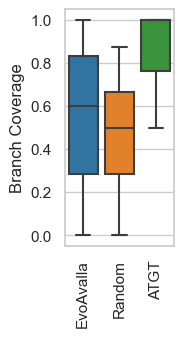

In [323]:
# Generate a box-plot with the update rule, macro and branch coverage for all three approaches
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(2, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='branch_coverage', data=all_data)
# set log scale for y-axis
plt.xlabel('')
plt.ylabel('Branch Coverage')
plt.tight_layout()
plt.xticks(rotation=90)

# Save the image as pdf
plt.savefig('images/boxplot_branch_coverage.pdf', bbox_inches='tight')

In [324]:
# For each approach, calculate the mean and standard deviation of the 'macro_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_macro_coverage = approach_data['macro_coverage'].mean()
    std_macro_coverage = approach_data['macro_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Macro Coverage: {mean_macro_coverage:.2f}, Std Dev: {std_macro_coverage:.2f}")

Approach: EvoAvalla, Mean Macro Coverage: 0.79, Std Dev: 0.33
Approach: Random, Mean Macro Coverage: 0.79, Std Dev: 0.30
Approach: ATGT, Mean Macro Coverage: 1.00, Std Dev: 0.00


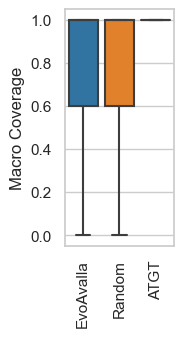

In [325]:
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(2, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='macro_coverage', data=all_data)
# set log scale for y-axis
plt.xlabel('')
plt.ylabel('Macro Coverage')
plt.tight_layout()
plt.xticks(rotation=90)

# Save the image as pdf
plt.savefig('images/boxplot_macro_coverage.pdf', bbox_inches='tight')

In [326]:
# For each approach, calculate the mean and standard deviation of the 'update_rule_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_update_rule_coverage = approach_data['update_rule_coverage'].mean()
    std_update_rule_coverage = approach_data['update_rule_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Update Rule Coverage: {mean_update_rule_coverage:.2f}, Std Dev: {std_update_rule_coverage:.2f}")

Approach: EvoAvalla, Mean Update Rule Coverage: 0.56, Std Dev: 0.37
Approach: Random, Mean Update Rule Coverage: 0.41, Std Dev: 0.29
Approach: ATGT, Mean Update Rule Coverage: 0.86, Std Dev: 0.25


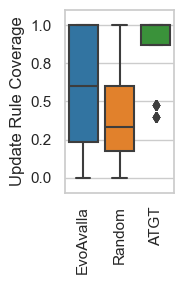

In [327]:
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(2, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='update_rule_coverage', data=all_data)
# set log scale for y-axis
plt.xlabel('')
plt.ylabel('Update Rule Coverage')
plt.xticks(rotation=90)
# Use only a single decimal for the y-axis
plt.yscale('linear')
plt.ylim(-0.1, 1.1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
plt.tight_layout()

# Save the image as pdf
plt.savefig('images/boxplot_updaterule_coverage.pdf', bbox_inches='tight')

## RQ3: Test generation time

Approach: EvoAvalla, Mean Execution Time: 80543.24, Std Dev: 14531.46
Approach: Random, Mean Execution Time: 13.68, Std Dev: 65.73
Approach: ATGT, Mean Execution Time: 795.74, Std Dev: 810.20


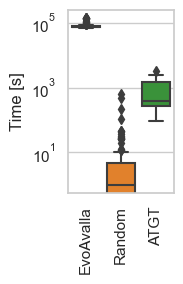

In [328]:
# For each approach, calculate the mean and standard deviation of the 'exec_time' column    
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_exec_time = approach_data['exec_time'].mean()
    std_exec_time = approach_data['exec_time'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Execution Time: {mean_exec_time:.2f}, Std Dev: {std_exec_time:.2f}")

# Generate a boxplot for the execution times of each approach
# Set the style of seaborn
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(2, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='exec_time', data=all_data)
# set log scale for y-axis
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Time [s]')
plt.xticks(rotation=90)
plt.tight_layout()

# Save the image as pdf
plt.savefig('images/boxplot_exec_time.pdf', bbox_inches='tight')

## RQ4: Size of test suites

In [329]:
# For each approach, calculate the mean and standard deviation of the 'n_scenarios' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_n_scenarios = approach_data['n_scenarios'].mean()
    std_n_scenarios = approach_data['n_scenarios'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Number of Scenarios: {mean_n_scenarios:.2f}, Std Dev: {std_n_scenarios:.2f}")

Approach: EvoAvalla, Mean Number of Scenarios: 3.81, Std Dev: 5.66
Approach: Random, Mean Number of Scenarios: 4.17, Std Dev: 5.56
Approach: ATGT, Mean Number of Scenarios: 5.87, Std Dev: 9.51


In [330]:
# For each approach, calculate the mean and standard deviation of the 'n_step' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_n_step = approach_data['n_step'].mean()
    std_n_step = approach_data['n_step'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Number of Steps: {mean_n_step:.2f}, Std Dev: {std_n_step:.2f}")

Approach: EvoAvalla, Mean Number of Steps: 7.83, Std Dev: 13.42
Approach: Random, Mean Number of Steps: 11.00, Std Dev: 14.50
Approach: ATGT, Mean Number of Steps: 160.38, Std Dev: 321.87


In [331]:
# For each approach, calculate the mean and standard deviation of the 'n_scenarios' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_n_scenarios = approach_data['n_scenarios'].mean()
    std_n_scenarios = approach_data['n_scenarios'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Number of Scenarios: {mean_n_scenarios:.2f}, Std Dev: {std_n_scenarios:.2f}")

Approach: EvoAvalla, Mean Number of Scenarios: 3.81, Std Dev: 5.66
Approach: Random, Mean Number of Scenarios: 4.17, Std Dev: 5.56
Approach: ATGT, Mean Number of Scenarios: 5.87, Std Dev: 9.51


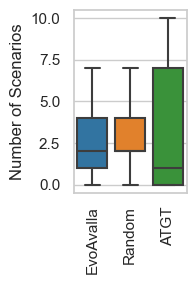

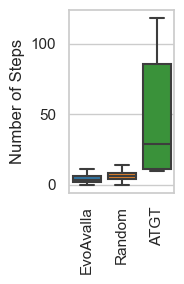

In [332]:
# Generate a figure containing two boxplots: one for the number of scenarios and one for the number of steps
plt.figure(figsize=(2, 3))
# Create a boxplot for the number of scenarios
sns.set(style="whitegrid")
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='n_scenarios', data=all_data, showfliers=False)
plt.xlabel('')
plt.ylabel('Number of Scenarios')
# Set x ticks to be rotated
plt.xticks(rotation=90)
plt.tight_layout()
# Save the image as pdf
plt.savefig('images/boxplot_n_scenarios.pdf', bbox_inches='tight')
# Create a boxplot for the number of steps
plt.figure(figsize=(2, 3))
sns.set(style="whitegrid")
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='n_step', data=all_data, showfliers=False)
plt.xlabel('')
plt.ylabel('Number of Steps')
# Set x ticks to be rotated
plt.xticks(rotation=90)
plt.tight_layout()
# Save the image as pdf
plt.savefig('images/boxplot_n_steps.pdf', bbox_inches='tight')